In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np

### Tennessee Eastman Process dataset:

Возможные причинно-следственные связи между 33 датчиками (из 52)
(из статьи "CIPCaD-Bench: Continuous Industrial Process datasets for benchmarking Causal Discovery methods"):

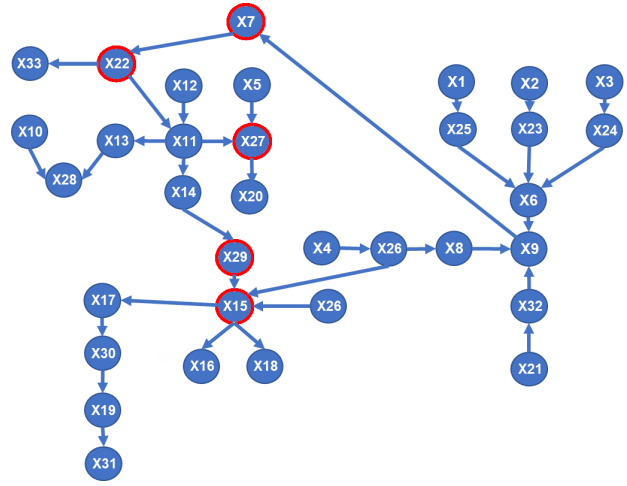

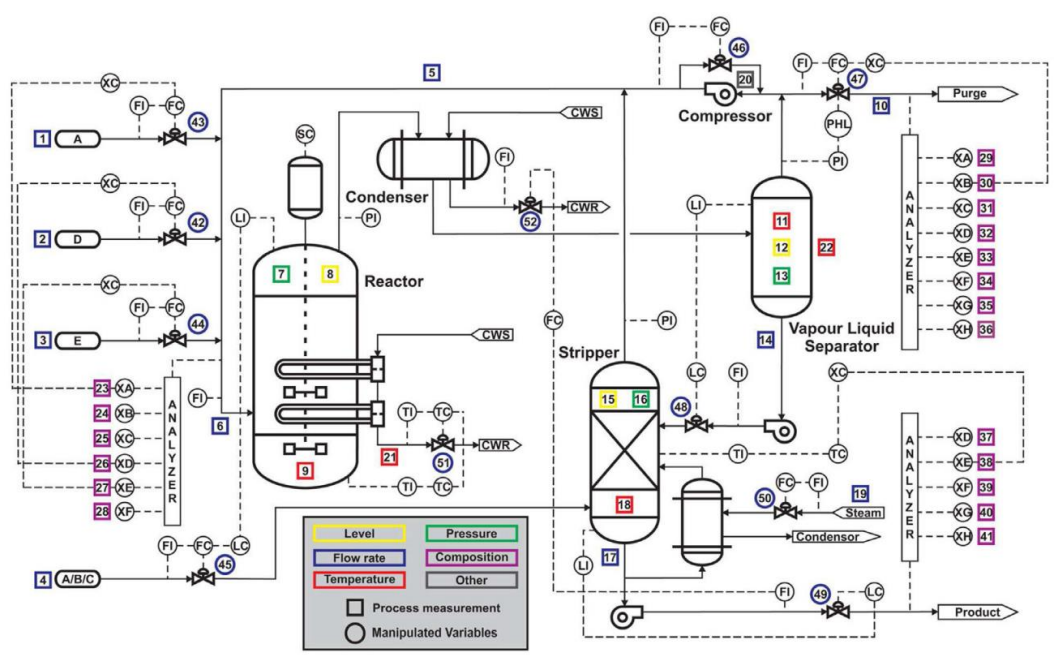

#### Установка Tennessee Eastman Process benchmark:

In [2]:
#!pip install git+https://github.com/airi-industrial-ai/fddbenchmark

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
from fddbenchmark import FDDDataset, FDDDataloader, FDDEvaluator

#### Загрузка датасета:

In [14]:
# 'small_tep'    - 20 faults, 18.9 MB
# 'rieth_tep'    - 20 faults, 1.84 GB
# 'reinartz_tep' - 28 faults, 1.88 GB

data = FDDDataset(name='small_tep')

Reading data/small_tep/test_mask.csv: 100%|██████████| 153300/153300 [00:00<00:00, 3075888.48it/s]


In [15]:
data.df

xmeas_1  xmeas_2  xmeas_3  xmeas_4  xmeas_5  xmeas_6  \
run_id    sample                                                         
413402073 1       0.25038   3674.0   4529.0   9.2320   26.889   42.402   
          2       0.25109   3659.4   4556.6   9.4264   26.721   42.576   
          3       0.25038   3660.3   4477.8   9.4426   26.875   42.070   
          4       0.24977   3661.3   4512.1   9.4776   26.758   42.063   
          5       0.29405   3679.0   4497.0   9.3381   26.889   42.650   
...                   ...      ...      ...      ...      ...      ...   
312148819 956     0.24842   3694.2   4491.2   9.3946   26.780   42.655   
          957     0.22612   3736.4   4523.1   9.3655   26.778   42.730   
          958     0.22386   3692.8   4476.5   9.3984   26.673   42.528   
          959     0.22561   3664.2   4483.0   9.4293   26.435   42.469   
          960     0.22585   3717.6   4492.8   9.4061   26.869   42.176   

                  xmeas_7  xmeas_8  xmeas_9  xmeas_10  ...   xmv_2   xmv_3  \
run_id    sample                                       ...                   
413402073 1        2704.3   74.863   120.41   0.33818  ...  53.744  24.657   
          2        2705.0   75.000   120.41   0.33620  ...  53.414  24.588   
          3        2706.2   74.771   120.42   0.33563  ...  54.357  24.666   
          4        2707.2   75.224   120.39   0.33553  ...  53.946  24.725   
          5        2705.1   75.388   120.39   0.32632  ...  53.658  28.797   
...                   ...      ...      ...       ...  ...     ...     ...   
312148819 956      2708.3   74.765   120.41   0.32959  ...  53.891  24.580   
          957      2711.0   75.142   120.38   0.32645  ...  53.675  21.831   
          958      2712.7   74.679   120.43   0.32484  ...  54.233  22.053   
          959      2710.2   74.857   120.38   0.31932  ...  53.335  22.248   
          960      2710.5   74.722   120.41   0.31926  ...  53.217  22.225   

                   xmv_4   xmv_5   xmv_6   xmv_7   xmv_8   xmv_9  xmv_10  \
run_id    sample                                                           
413402073 1       62.544  22.137  39.935  42.323  47.757  47.510  41.258   
          2       59.259  22.084  40.176  38.554  43.692  47.427  41.359   
          3       61.275  22.380  40.244  38.990  46.699  47.468  41.199   
          4       59.856  22.277  40.257  38.072  47.541  47.658  41.643   
          5       60.717  21.947  39.144  41.955  47.645  47.346  41.507   
...                  ...     ...     ...     ...     ...     ...     ...   
312148819 956     63.320  21.867  38.868  36.061  48.088  45.470  41.463   
          957     64.142  22.027  38.842  39.144  44.560  45.598  41.591   
          958     59.228  22.235  39.040  35.116  45.737  45.490  41.884   
          959     60.567  21.820  37.979  33.394  48.503  45.512  40.630   
          960     63.429  22.259  37.986  34.810  47.810  45.639  41.898   

                  xmv_11  
run_id    sample          
413402073 1       18.447  
          2       17.194  
          3       20.530  
          4       18.089  
          5       18.461  
...                  ...  
312148819 956     17.078  
          957     16.720  
          958     16.310  
          959     20.996  
          960     18.378  

[153300 rows x 52 columns]

#### Стандартизация данных:

In [16]:
data.df = (data.df - data.df.mean()) / data.df.std()
data.df

xmeas_1   xmeas_2   xmeas_3   xmeas_4   xmeas_5   xmeas_6  \
run_id    sample                                                               
413402073 1      -0.055360  0.207437  0.193062 -0.403592 -0.049606  0.084676   
          2      -0.050364 -0.138872  0.447438  0.121124 -0.785999  0.628572   
          3      -0.055360 -0.117524 -0.278822  0.164851 -0.110973 -0.953102   
          4      -0.059652 -0.093804  0.037304  0.259321 -0.623817 -0.974983   
          5       0.251922  0.326037 -0.101865 -0.117211 -0.049606  0.859884   
...                    ...       ...       ...       ...       ...       ...   
312148819 956    -0.069151  0.686578 -0.155321  0.035291 -0.527385  0.875513   
          957    -0.226064  1.687554  0.138685 -0.043254 -0.536152  1.109951   
          958    -0.241966  0.653370 -0.290804  0.045548 -0.996397  0.478531   
          959    -0.229653 -0.025017 -0.230896  0.128952 -2.039620  0.294107   
          960    -0.227964  1.241622 -0.140575  0.066331 -0.137272 -0.621763   

                   xmeas_7   xmeas_8   xmeas_9  xmeas_10  ...     xmv_2  \
run_id    sample                                          ...             
413402073 1      -0.245511 -0.012534  0.146646 -0.069412  ... -0.118149   
          2      -0.236406  0.091571  0.146646 -0.093771  ... -0.166602   
          3      -0.220796 -0.082443  0.292983 -0.100783  ... -0.028143   
          4      -0.207788  0.261785 -0.146029 -0.102013  ... -0.088490   
          5      -0.235105  0.386407 -0.146029 -0.215318  ... -0.130776   
...                    ...       ...       ...       ...  ...       ...   
312148819 956    -0.193479 -0.087003  0.146646 -0.175089  ... -0.096565   
          957    -0.158358  0.199475 -0.292366 -0.213718  ... -0.128280   
          958    -0.136245 -0.152353  0.439320 -0.233525  ... -0.046350   
          959    -0.168764 -0.017093 -0.292366 -0.301434  ... -0.178202   
          960    -0.164862 -0.119678  0.146646 -0.302172  ... -0.195528   

                     xmv_3     xmv_4     xmv_5     xmv_6     xmv_7     xmv_8  \
run_id    sample                                                               
413402073 1      -0.249044 -0.111364 -0.069564  0.038450  1.431693  0.562344   
          2      -0.252586 -0.524065 -0.074254  0.057227  0.166080 -1.177241   
          3      -0.248582 -0.270791 -0.048059  0.062525  0.312487  0.109581   
          4      -0.245552 -0.449063 -0.057174  0.063538  0.004227  0.469908   
          5      -0.036482 -0.340893 -0.086378 -0.023181  1.308120  0.514414   
...                    ...       ...       ...       ...       ...       ...   
312148819 956    -0.252997 -0.013873 -0.093458 -0.044686 -0.671058  0.703993   
          957    -0.394140  0.089396 -0.079299 -0.046712  0.364199 -0.805787   
          958    -0.382742 -0.527959 -0.060891 -0.031284 -0.988384 -0.302099   
          959    -0.372730 -0.359738 -0.097618 -0.113952 -1.566624  0.881588   
          960    -0.373911 -0.000179 -0.058767 -0.113407 -1.091138  0.585025   

                     xmv_9    xmv_10    xmv_11  
run_id    sample                                
413402073 1      -0.132831 -0.033011 -0.095691  
          2      -0.137626 -0.023895 -0.242056  
          3      -0.135257 -0.038335  0.147627  
          4      -0.124280  0.001735 -0.137510  
          5      -0.142306 -0.010539 -0.094056  
...                    ...       ...       ...  
312148819 956    -0.250689 -0.014510 -0.255606  
          957    -0.243294 -0.002958 -0.297424  
          958    -0.249533  0.023485 -0.345317  
          959    -0.248262 -0.089687  0.202061  
          960    -0.240925  0.024749 -0.103751  

[153300 rows x 52 columns]

#### Создание загрузчиков данных:

In [24]:
train_dl = FDDDataloader(
    dataframe=data.df,
    mask=data.train_mask,
    labels=data.labels,
    window_size=10,
    step_size=1,
    minibatch_training=True,
    batch_size=512,
    shuffle=True
)

test_dl = FDDDataloader(
    dataframe=data.df,
    mask=data.test_mask,
    labels=data.labels,
    window_size=10, 
    step_size=1, 
    minibatch_training=True,
    batch_size=512
)

evaluator = FDDEvaluator(
    step_size=test_dl.step_size
    )

Creating sequence of samples: 100%|██████████| 105/105 [00:00<00:00, 791.65it/s]


In [41]:
t = []
i = 0

for train_ts, train_index, train_label in test_dl:

    t.extend(train_ts)
        
    #i+=1
    

In [42]:
np.shape(np.array(t)[:2000])

(2000, 30, 52)

In [43]:
np.save('test_small.npy', np.array(t)[:2000].reshape((2000, 30, 1, 52)))

In [20]:
np.array(t).reshape((4935, 30, 1, 52))

array([[[[ 2.19132183e-01, -7.93538850e-01,  5.57366314e-02, ...,
           1.45499890e-02, -8.36401191e-02, -1.66712398e-01]],

        [[ 2.10547715e-01, -5.27876889e-01,  3.35918115e-01, ...,
           2.81268018e-02, -2.90396361e-02,  1.74026482e-01]],

        [[ 4.41343243e-01, -1.10408093e-01,  5.96755202e-03, ...,
           4.73654343e-02, -1.41485952e-02, -1.14614510e-01]],

        ...,

        [[ 8.58618389e-02, -5.30248871e-01, -4.28798777e-02, ...,
           4.14112700e-01, -9.57334492e-02, -3.37257055e-01]],

        [[ 6.42032963e-03,  1.08269875e+00,  2.15182015e-01, ...,
           4.03424570e-01,  2.79073140e-02, -4.28923045e-02]],

        [[-2.79741857e-03,  1.24873747e+00, -1.68224226e-01, ...,
           4.01518039e-01, -5.48507735e-02, -2.96022628e-01]]],


       [[[-1.63521137e+00,  3.37896466e-01, -2.92646924e-01, ...,
          -7.65741215e-01, -4.40209256e-02, -6.49696608e-02]],

        [[-1.62087109e+00,  2.26413321e-01, -5.30432526e-01, ...,
        

In [18]:
train_dl[0]

TypeError: 'FDDDataloader' object is not subscriptable

#### Модель графовой нейронной сети:

In [35]:
# Сверточный графовый слой:
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        # Данные агрегируются после линейного слоя:
        self.dense = nn.Linear(in_dim, out_dim)

    def forward(self, adj, X):
        # adj - матрица смежности
        # Добавление self loops:
        #adj = adj + torch.eye(adj.size(0)).to(adj.device)
        h = self.dense(X)
        norm = adj.sum(1)**(-1/2)
        h = norm[None, :] * adj * norm[:, None] @ h
        
        return h
    

#Directed adjacency matrix   
class Graph_Directed_A(nn.Module):
      
    def __init__(self, num_nodes=52, window_size=10, alpha=1, device=None):
        super(Graph_Directed_A, self).__init__()
        
        self.alpha = alpha
        self.k = None
        self.device = device
        
        self.e1 = nn.Embedding(num_nodes, window_size)
        self.e2 = nn.Embedding(num_nodes, window_size)
        self.l1 = nn.Linear(window_size,window_size)
        self.l2 = nn.Linear(window_size,window_size)
        
    def forward(self, idx):
        
        m1 = torch.tanh(self.alpha*self.l1(self.e1(idx)))
        m2 = torch.tanh(self.alpha*self.l2(self.e2(idx)))
        adj = F.relu(torch.tanh(self.alpha*torch.mm(m1, m2.transpose(1,0))))
        
        if self.k:
            mask = torch.zeros(idx.size(0), idx.size(0)).to(self.device)
            mask.fill_(float('0'))
            s1,t1 = (adj + torch.rand_like(adj)*0.01).topk(self.k,1)
            mask.scatter_(1,t1,s1.fill_(1))
            adj = adj*mask
            
        adj = adj + torch.eye(52).to(self.device)
        
        return adj

    
# Графовая нейронная сеть:
class GNN(nn.Module):    
    def __init__(self, A = None, device=None):
        super(GNN, self).__init__()
        self.device = device
        self.pred = False
        if A != None:
            self.adj = A.to(device)
            self.pred = True
        else:
            self.graph_struct = Graph_Directed_A(device=device)
        self.idx = torch.arange(52).to(device)
        
        self.conv1 = GCNLayer(10, 256)
        self.bnorm1 = nn.BatchNorm1d(52)
        self.conv2 = GCNLayer(256, 256)
        self.bnorm2 = nn.BatchNorm1d(52)
        self.fc = nn.Linear(256, 21)
    
    
    def forward(self, X):
        if not self.pred:
            self.adj = self.graph_struct(self.idx)
        # first gcn layer:
        h = self.conv1(self.adj, X.to(self.device)).relu()
        h = self.bnorm1(h)
        skip, _ = torch.min(h,dim=1)
        h = self.conv2(self.adj, h).relu()
        h = self.bnorm2(h)
        h, _ = torch.min(h,dim=1)
        h = h + skip
        
        output = self.fc(h)
        
        return output

#### Код для тренировки модели и подсчета метрик:

In [36]:
def train_and_evaluate(adj_matrix = None):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GNN(A=adj_matrix,device=device)
    model.to(device)
    optimizer = Adam(model.parameters())
    n_epochs = 30
    weight = torch.ones(21) * 0.5
    weight[2:] /= 20
    
    model.train()
    print(" Training:")
    for e in range(n_epochs):
        av_loss = []
        for train_ts, train_index, train_label in train_dl:
            m = torch.FloatTensor(train_ts)
            v_train_ts = torch.transpose(m, 1, 2)
            train_label = torch.LongTensor(train_label.values).to(device)
            logits = model(v_train_ts)
            loss = F.cross_entropy(logits, train_label, weight=weight.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            av_loss.append(loss.item())
        print(f'Epoch: {e+1:2d}/{n_epochs}, average CE loss: {sum(av_loss)/len(av_loss):.4f}')
    
    print("\n Evaluation:")
    preds = []
    test_labels = []
    model.eval()
    for test_ts, test_index, test_label in test_dl:
        m = torch.FloatTensor(test_ts)
        v_test_ts = torch.transpose(m, 1, 2)
        with torch.no_grad():
            logits = model(v_test_ts)
        pred = logits.argmax(axis=1).cpu().numpy()
        preds.append(pd.Series(pred, index=test_index))
        test_labels.append(test_label)
    pred = pd.concat(preds)
    test_label = pd.concat(test_labels)
    
    evaluator = FDDEvaluator(
    step_size=test_dl.step_size
    )
    evaluator.print_metrics(test_label, pred)

#### Результат для матрицы корреляции:

In [72]:
corr = data.df.corr(method='pearson')

In [72]:
abs(corr)

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
xmeas_1,1.000000,0.174080,0.176367,0.585188,0.011004,0.179723,0.508820,0.141425,0.034466,0.146352,...,0.178352,0.334739,0.471411,0.187873,0.331056,0.048658,0.101111,0.021167,0.054600,0.200973
xmeas_2,0.174080,1.000000,0.479310,0.297129,0.013553,0.302182,0.173940,0.006787,0.029986,0.125807,...,0.397230,0.351676,0.073661,0.001933,0.013365,0.080008,0.067587,0.274932,0.027425,0.017819
xmeas_3,0.176367,0.479310,1.000000,0.205474,0.013547,0.193354,0.076613,0.267495,0.067460,0.256227,...,0.581480,0.567807,0.057201,0.007881,0.154467,0.132852,0.071215,0.635243,0.044867,0.030516
xmeas_4,0.585188,0.297129,0.205474,1.000000,0.008630,0.661175,0.534159,0.698140,0.015892,0.099487,...,0.555643,0.293975,0.608755,0.146869,0.237287,0.113682,0.118229,0.151207,0.073811,0.099654
xmeas_5,0.011004,0.013553,0.013547,0.008630,1.000000,0.025316,0.013956,0.011068,0.011395,0.003818,...,0.017751,0.005036,0.007947,0.049350,0.011119,0.002545,0.009473,0.010161,0.025846,0.007943
xmeas_6,0.179723,0.302182,0.193354,0.661175,0.025316,1.000000,0.298019,0.538262,0.023730,0.198477,...,0.450816,0.188223,0.366380,0.068157,0.044462,0.089817,0.068414,0.141701,0.078424,0.018224
xmeas_7,0.508820,0.173940,0.076613,0.534159,0.013956,0.298019,1.000000,0.227831,0.016755,0.365021,...,0.323100,0.314712,0.723883,0.318307,0.698836,0.061036,0.175450,0.195385,0.081586,0.416428
xmeas_8,0.141425,0.006787,0.267495,0.698140,0.011068,0.538262,0.227831,1.000000,0.060065,0.057042,...,0.256430,0.002525,0.458707,0.055578,0.151992,0.039469,0.032207,0.125355,0.105272,0.015912
xmeas_9,0.034466,0.029986,0.067460,0.015892,0.011395,0.023730,0.016755,0.060065,1.000000,0.010469,...,0.021407,0.029595,0.000032,0.041993,0.013516,0.008515,0.012499,0.017977,0.195981,0.008170
xmeas_10,0.146352,0.125807,0.256227,0.099487,0.003818,0.198477,0.365021,0.057042,0.010469,1.000000,...,0.017094,0.209596,0.183018,0.123245,0.885766,0.026062,0.055079,0.314684,0.051186,0.202895


In [83]:
torch.save(A, 'corr_A.pt')

In [73]:
coef = 0.7
A = torch.FloatTensor(abs(corr).values)
#A[(A > coef) | (A < -coef)] = 1
#A[A < 1] = 0
#train_and_evaluate(A)

In [75]:
A[(A > coef)] = 1
A[A < 1] = 0

In [157]:
list_names = list(data.df.columns)

In [179]:
new_matrix = pd.DataFrame(index=list_names, columns=list_names)
new_matrix = new_matrix.fillna(0)

for i, row in matrix.iterrows():
    
    new_matrix.loc[row[0],row[1]] = row[2]*100
    new_matrix.loc[row[1],row[0]] = row[2]*100
#np.fill_diagonal(new_matrix.values, 1)

In [193]:
dat = matrix.values
np.fill_diagonal(dat, 1)

dat

array([[1.        , 0.05309368, 0.01157422, ..., 0.02323688, 0.02654379,
        0.03583784],
       [0.01362474, 1.        , 0.41210262, ..., 0.01910084, 0.02534552,
        0.01328012],
       [0.0164138 , 0.40258234, 1.        , ..., 0.02271285, 0.02343485,
        0.02000161],
       ...,
       [0.        , 0.02177929, 0.02619322, ..., 1.        , 0.01157016,
        0.        ],
       [0.02015779, 0.02040258, 0.02779049, ..., 0.        , 1.        ,
        0.01385393],
       [0.03228803, 0.01977261, 0.01805827, ..., 0.        , 0.02140424,
        1.        ]])

In [198]:
dat[:][1]

array([0.01362474, 1.        , 0.41210262, 0.01098562, 0.02452067,
       0.03145191, 0.07919105, 0.03073459, 0.02959375, 0.01618284,
       0.01205494, 0.02513544, 0.08583137, 0.03076962, 0.01420111,
       0.07023019, 0.01312333, 0.02709474, 0.01655446, 0.05297253,
       0.01893825, 0.0366167 , 0.01314389, 0.013973  , 0.02206643,
       0.        , 0.01824783, 0.01688146, 0.02430537, 0.02010501,
       0.02702483, 0.01690956, 0.02329061, 0.        , 0.01112688,
       0.01317378, 0.02966304, 0.01847011, 0.01317658, 0.02165238,
       0.02674445, 0.01136437, 0.03159453, 0.01337344, 0.01811164,
       0.02420695, 0.01722771, 0.01376656, 0.02291747, 0.01910084,
       0.02534552, 0.01328012])

In [145]:
Matrix = new_matrix*100
np.fill_diagonal(Matrix.values, 1)

In [147]:
np.fill_diagonal(Matrix.values,1)

In [19]:
matrix = pd.read_csv('/home/jovyan/ABC_dima.csv', sep='\t', header=None)
dim_A = torch.FloatTensor(matrix.values)

In [12]:
np.shape(A)

NameError: name 'A' is not defined

In [25]:
dagma = pd.read_csv('/home/jovyan/Dagma_new_digital.csv', sep = '\t', index_col=0)

In [33]:
A = torch.FloatTensor(np.round((dagma*10).values, 1))

#### Матрица обучается в модели:

In [34]:
train_and_evaluate(dim_A) # второй энкодер

 Training:
Epoch:  1/30, average CE loss: 1.6550
Epoch:  2/30, average CE loss: 1.3772
Epoch:  3/30, average CE loss: 1.2806
Epoch:  4/30, average CE loss: 1.2129
Epoch:  5/30, average CE loss: 1.1580
Epoch:  6/30, average CE loss: 1.1126
Epoch:  7/30, average CE loss: 1.0763
Epoch:  8/30, average CE loss: 1.0475
Epoch:  9/30, average CE loss: 1.0247
Epoch: 10/30, average CE loss: 1.0056
Epoch: 11/30, average CE loss: 0.9893
Epoch: 12/30, average CE loss: 0.9749
Epoch: 13/30, average CE loss: 0.9622


KeyboardInterrupt: 

In [13]:
train_and_evaluate(dim_A) # другое округление первый энкодер

 Training:
Epoch:  1/30, average CE loss: 2.0820
Epoch:  2/30, average CE loss: 1.7526
Epoch:  3/30, average CE loss: 1.1462
Epoch:  4/30, average CE loss: 0.9271
Epoch:  5/30, average CE loss: 0.8285
Epoch:  6/30, average CE loss: 0.7772
Epoch:  7/30, average CE loss: 0.7378
Epoch:  8/30, average CE loss: 0.7075
Epoch:  9/30, average CE loss: 0.6817
Epoch: 10/30, average CE loss: 0.6557
Epoch: 11/30, average CE loss: 0.6387
Epoch: 12/30, average CE loss: 0.6218
Epoch: 13/30, average CE loss: 0.6089
Epoch: 14/30, average CE loss: 0.6007
Epoch: 15/30, average CE loss: 0.5929
Epoch: 16/30, average CE loss: 0.5861
Epoch: 17/30, average CE loss: 0.5792
Epoch: 18/30, average CE loss: 0.5637
Epoch: 19/30, average CE loss: 0.5485
Epoch: 20/30, average CE loss: 0.5367
Epoch: 21/30, average CE loss: 0.5272
Epoch: 22/30, average CE loss: 0.5193
Epoch: 23/30, average CE loss: 0.5128
Epoch: 24/30, average CE loss: 0.5092
Epoch: 25/30, average CE loss: 0.5028
Epoch: 26/30, average CE loss: 0.4986
E

In [182]:
train_and_evaluate(A)

 Training:
Epoch:  1/40, average CE loss: 2.0453
Epoch:  2/40, average CE loss: 1.4887
Epoch:  3/40, average CE loss: 1.1935
Epoch:  4/40, average CE loss: 0.9858
Epoch:  5/40, average CE loss: 0.8783
Epoch:  6/40, average CE loss: 0.8201
Epoch:  7/40, average CE loss: 0.7770
Epoch:  8/40, average CE loss: 0.7440
Epoch:  9/40, average CE loss: 0.7217
Epoch: 10/40, average CE loss: 0.6970
Epoch: 11/40, average CE loss: 0.6756
Epoch: 12/40, average CE loss: 0.6522
Epoch: 13/40, average CE loss: 0.6292
Epoch: 14/40, average CE loss: 0.6135
Epoch: 15/40, average CE loss: 0.5963
Epoch: 16/40, average CE loss: 0.5854
Epoch: 17/40, average CE loss: 0.5777
Epoch: 18/40, average CE loss: 0.5664
Epoch: 19/40, average CE loss: 0.5583
Epoch: 20/40, average CE loss: 0.5477
Epoch: 21/40, average CE loss: 0.5371
Epoch: 22/40, average CE loss: 0.5264
Epoch: 23/40, average CE loss: 0.5187
Epoch: 24/40, average CE loss: 0.5126
Epoch: 25/40, average CE loss: 0.5053
Epoch: 26/40, average CE loss: 0.5013
E

## Тест своей матрицы смежности:

In [31]:
# Надо загрузить свою:

A = torch.load('NRIscratch.pt', map_location=torch.device('cuda'))
#train_and_evaluate(A)

In [32]:
A

tensor([[0.0000, 0.0000, 0.0644,  ..., 0.0000, 0.0000, 0.0000],
        [0.0640, 0.0000, 0.0000,  ..., 0.0076, 0.0660, 0.0793],
        [0.0329, 0.0000, 0.0000,  ..., 0.0145, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0115, 0.0000, 0.0140,  ..., 0.0000, 0.0000, 0.0000],
        [0.0124, 0.0000, 0.0553,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', requires_grad=True)

In [33]:
A = A + torch.eye(52).to(device)

In [37]:
train_and_evaluate(A)

 Training:
Epoch:  1/30, average CE loss: 1.2667
Epoch:  2/30, average CE loss: 0.9071
Epoch:  3/30, average CE loss: 0.7649
Epoch:  4/30, average CE loss: 0.6877
Epoch:  5/30, average CE loss: 0.6348
Epoch:  6/30, average CE loss: 0.5970
Epoch:  7/30, average CE loss: 0.5691
Epoch:  8/30, average CE loss: 0.5463
Epoch:  9/30, average CE loss: 0.5279
Epoch: 10/30, average CE loss: 0.5126
Epoch: 11/30, average CE loss: 0.4998
Epoch: 12/30, average CE loss: 0.4888
Epoch: 13/30, average CE loss: 0.4791
Epoch: 14/30, average CE loss: 0.4703
Epoch: 15/30, average CE loss: 0.4622
Epoch: 16/30, average CE loss: 0.4545
Epoch: 17/30, average CE loss: 0.4475
Epoch: 18/30, average CE loss: 0.4415
Epoch: 19/30, average CE loss: 0.4355
Epoch: 20/30, average CE loss: 0.4306
Epoch: 21/30, average CE loss: 0.4254
Epoch: 22/30, average CE loss: 0.4208
Epoch: 23/30, average CE loss: 0.4162
Epoch: 24/30, average CE loss: 0.4130
Epoch: 25/30, average CE loss: 0.4085
Epoch: 26/30, average CE loss: 0.4043
E